# Percolation keras

## initializations

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#standard libraries
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

import random as rn
import os
import matplotlib.pyplot as plt
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 

In [3]:
#machine learning libraries
import tensorflow as tf 
import keras
print("tensorflow: ",tf.__version__, ", keras: ", keras.__version__)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
print("sklearn: ", sklearn.__version__)

tensorflow:  2.0.0 , keras:  2.3.1
sklearn:  0.22.1


Using TensorFlow backend.


In [4]:
import numpy as np
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 
from keras.models import Sequential
import keras
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Conv1D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import os

## starting the main code

In [5]:
myseed = 123467

np.random.seed(myseed) # necessary for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(myseed+1) # necessary for starting core Python generated random numbers in a well-defined state.

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

os.environ['PYTHONHASHSEED'] = '0'

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v2.random.set_seed(myseed+3)
#tf.set_random_seed(1234)

#sess = tf.compat.v2.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

## reading the images

In [6]:
img_sizeX= 100
img_sizeY= 100 #img_sizeX
validation_split= 0.1

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=validation_split)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 16
num_classes=2

dataname = 'Percolation_training_set_1000_Ohtsuki_Resnet'
datapath = '../'+dataname
modelname = '/model_'+dataname
modelpath = datapath+modelname


In [8]:
training_set = train_datagen.flow_from_directory('training_set_1000',
                                                 subset='training',
                                                 target_size = (img_sizeX, img_sizeY),
                                                 batch_size = batch_size, 
                                                 class_mode='binary',
                                                shuffle=True)




validation_set= train_datagen.flow_from_directory('training_set_1000', 
                                              subset='validation', 
                                              target_size = (img_sizeX, img_sizeY),
                                              batch_size = batch_size,
                                              class_mode='binary',
                                                 shuffle=False)

Found 9001 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


In [9]:
num_of_train_samples = training_set.samples
num_of_test_samples = validation_set.samples
num_classes = len(validation_set.class_indices)

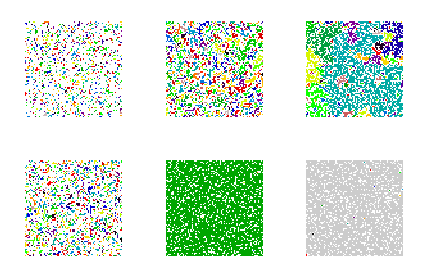

In [10]:
#plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in training_set:
        plt.imshow(x[0],cmap='hsv')
        #plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

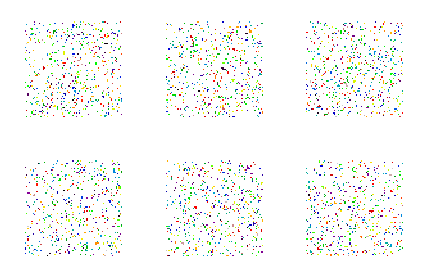

In [11]:
#plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in validation_set:
        plt.imshow(x[0],cmap='hsv')
        #plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

## building the CNN

In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(img_sizeX, img_sizeY, 3))

In [13]:
model = Sequential([
  resnet,Flatten(),
  Dense(1, activation='sigmoid'),
])

In [14]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
# model.summary()

In [16]:
mylr=1.0 
mywd=1e-6
rho=0.95
# Choose the Optimizer and the Cost Function

# opt = optimizers.SGD(lr=mylr, decay=mywd)
opt1 = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6)
opt2=tf.keras.optimizers.Adam(lr=0.00001, decay=1e-6)
opt3=tf.keras.optimizers.Adadelta(learning_rate=mylr, rho=rho)
#opt = keras.optimizers.Adam(lr=mylr, decay=mywd)

def compile_model(optimizer=opt3):
       # compile the model
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [17]:
# opt = optimizers.SGD(lr=mylr, decay=mywd)
# model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# create the deep neural net
model = compile_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 32769     
Total params: 23,620,481
Trainable params: 23,567,361
Non-trainable params: 53,120
_________________________________________________________________
None


## learning the images

In [18]:
# training parameters
myepochs=10

In [19]:
# train DNN and store training info in history
history = model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples // batch_size,
                         epochs = myepochs,
                         validation_data = validation_set,
                         validation_steps = validation_set.samples // batch_size)

Epoch 1/10
562/562 [==============================] - 84s 150ms/step - loss: 0.2298 - accuracy: 0.9289 - val_loss: 8.5322 - val_accuracy: 0.4435
Epoch 2/10
562/562 [==============================] - 84s 149ms/step - loss: 0.1147 - accuracy: 0.9521 - val_loss: 0.1079 - val_accuracy: 0.9496
Epoch 3/10
562/562 [==============================] - 84s 150ms/step - loss: 0.1031 - accuracy: 0.9602 - val_loss: 0.1353 - val_accuracy: 0.9335
Epoch 4/10
562/562 [==============================] - 84s 149ms/step - loss: 0.0993 - accuracy: 0.9675 - val_loss: 0.0895 - val_accuracy: 0.9597
Epoch 5/10
562/562 [==============================] - 84s 150ms/step - loss: 0.0484 - accuracy: 0.9819 - val_loss: 0.2564 - val_accuracy: 0.8800
Epoch 6/10
562/562 [==============================] - 82s 147ms/step - loss: 0.0326 - accuracy: 0.9889 - val_loss: 0.1942 - val_accuracy: 0.9274
Epoch 7/10
562/562 [==============================] - 83s 148ms/step - loss: 0.0201 - accuracy: 0.9932 - val_loss: 0.1400 - val_ac

In [25]:
# model.save('Percolation_spanning_sgd_01_copy.h5') 
model.save(modelpath+'.h5')

In [26]:
import pickle
f=open(modelpath+'_history.pickle',"wb")
pickle.dump(history.history,f)
f.close()

## testing the quality of the learned model

63/63 [==============================] - 3s 51ms/step - loss: 0.5682 - accuracy: 0.8589

Test loss: 0.5681515965196845
Test accuracy: 0.8588589


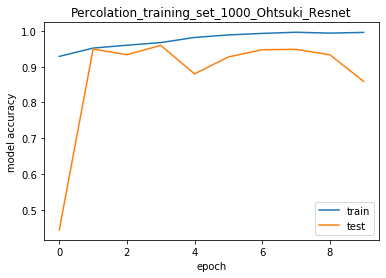

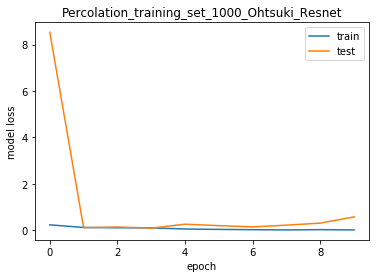

In [27]:
# evaluate model
score=model.evaluate(validation_set,verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
fig=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+dataname+'_accuracy'+'.png')

# summarize history for loss
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+dataname+'_loss'+'.png')

In [28]:
num_of_train_samples = training_set.samples
num_of_test_samples =validation_set.samples

validation_set.reset()
labels=validation_set.class_indices.keys()

#Confusion Matrix 
Y_pred =model.predict_generator(validation_set,validation_set.samples // batch_size+1, verbose=1)
y_pred=(Y_pred > 0.5).astype(int)

#basic confusion matrix
conf=confusion_matrix(validation_set.classes, y_pred)
conf

63/63 [==============================] - 3s 48ms/step


array([[552,   0],
       [141, 306]])

In [29]:
import pandas as pd
cm=pd.DataFrame(conf, index=labels, columns=labels)
cm

,no_percolation,percolation
no_percolation,552,0
percolation,141,306


In [30]:
cm.to_csv(modelpath+"confusion_matrix.txt", header=True, index=True, sep='\t', mode='a')

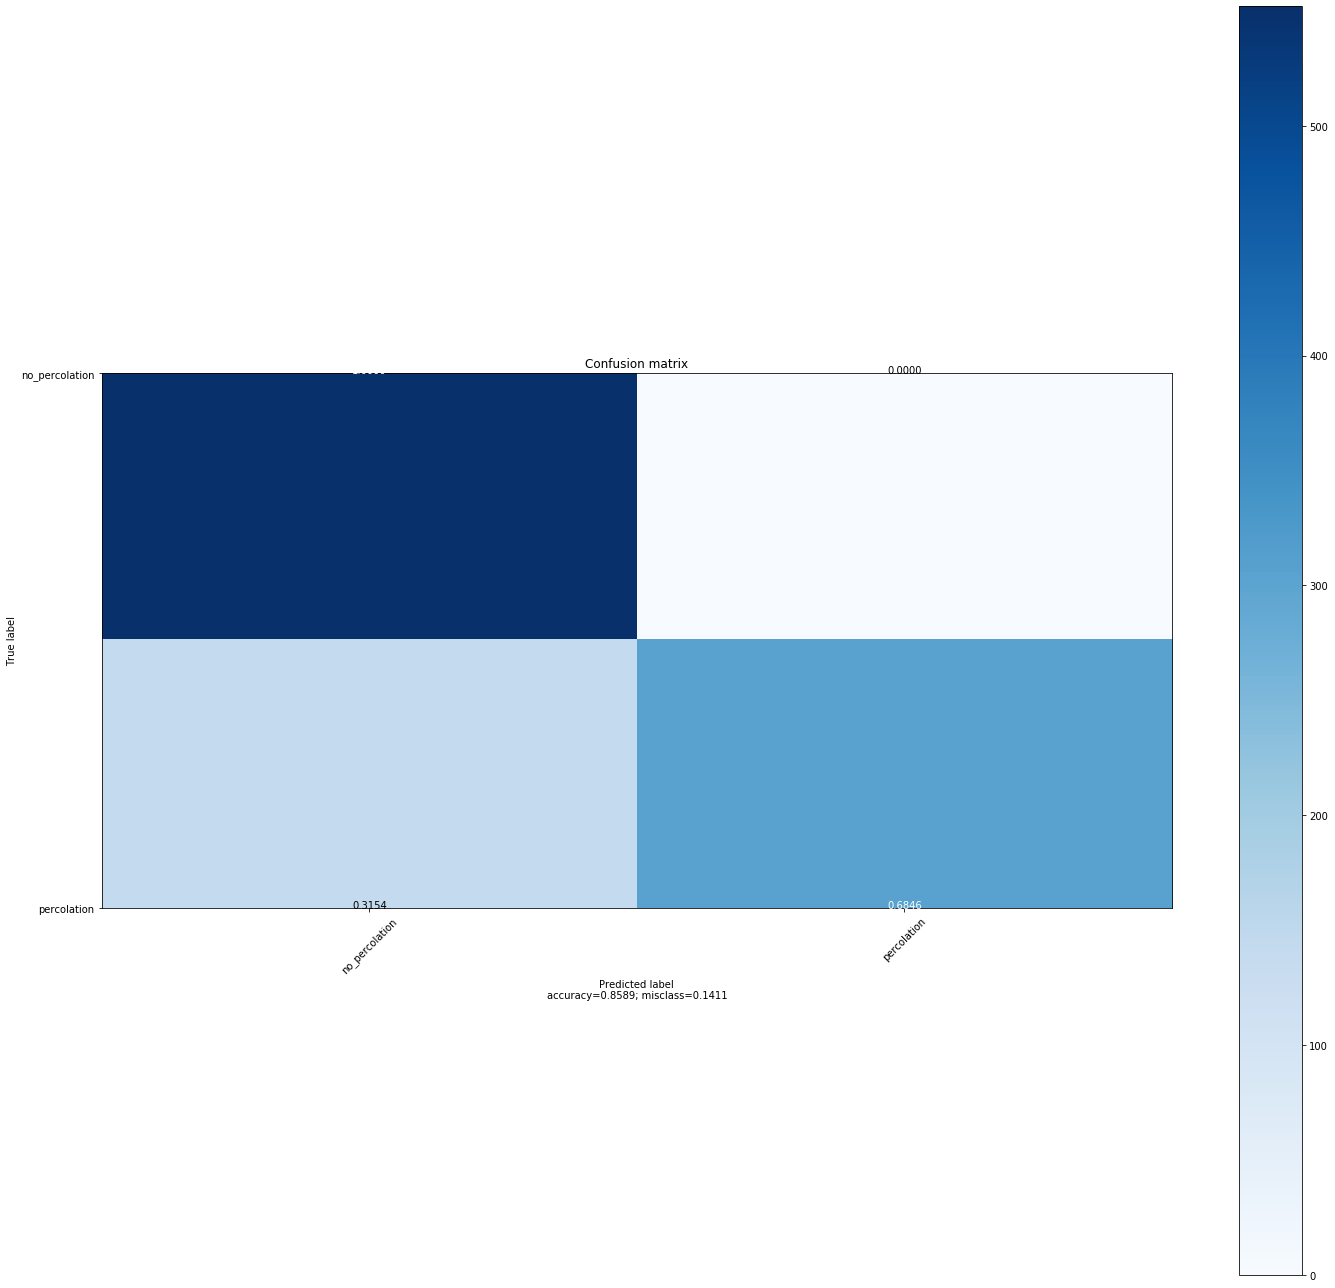

None


In [31]:
from plot_confusion_matrix import *
label=validation_set.class_indices.keys()
print(plot_confusion_matrix(confusion_matrix(validation_set.classes, y_pred),
                          labels,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True))

## modify the Hyperparameters to Optimize Performance of the Model

In [32]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [33]:
X_train, X_labels = next(training_set)
Y_train, Y_labels = next(validation_set)
len(X_train),len(X_labels),len(Y_train),len(Y_labels)

(16, 16, 16, 16)

In [34]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=1, 
                        batch_size=batch_size, 
                        verbose=1)

# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# define parameter dictionary
param_grid = dict(optimizer=optimizer)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(X_train,X_labels)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Train on 12 samples
4/1 [========================================================================================================================] - 1s 251ms/sample - loss: 0.0010 - accuracy: 1.0000
Train on 12 samples
4/1 [========================================================================================================================] - 1s 167ms/sample - loss: 0.0018 - accuracy: 1.0000
Train on 12 samples
4/1 [========================================================================================================================] - 1s 234ms/sample - loss: 2.9981e-14 - accuracy: 1.0000
Train on 12 samples
4/1 [========================================================================================================================] - 1s 161ms/sample - loss: 8.2022e-07 - accuracy: 1.0000
Train on 12 samples
4/1 [========================================================================================================================] - 1s 263ms/sample - loss: 0.0248 - accuracy: 1.00

Train on 16 samples
16/16 [==============================] - 4s 277ms/sample - loss: 4.4138e-10 - accuracy: 1.0000
Best: 1.000000 using {'optimizer': 'SGD'}
1.000000 (0.000000) with: {'optimizer': 'SGD'}
0.812500 (0.207289) with: {'optimizer': 'RMSprop'}
0.375000 (0.279508) with: {'optimizer': 'Adagrad'}
0.437500 (0.272431) with: {'optimizer': 'Adadelta'}
0.562500 (0.108253) with: {'optimizer': 'Adam'}
0.750000 (0.176777) with: {'optimizer': 'Adamax'}
0.750000 (0.176777) with: {'optimizer': 'Nadam'}
